In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [5]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from dm_ham import DMOp

In [103]:

L = 4
g = nk.graph.Triangular(extent=[L, L], pbc=True)


In [116]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)

In [124]:
# calling the Heisenberg Hamiltonian
# ha = DMOp(hilbert=hi, graph=g, J=1)
ha = nk.operator.Heisenberg(hilbert=hi, graph=g, J=-1)

In [125]:
exact_gs_energy = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
# evals2, state2 = nk.exact.full_ed(ha, compute_eigenvectors=True)



In [126]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

In [127]:
ma = Jastrow()

In [131]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

sigmaz = np.sum([nk.operator.spin.sigmaz(hi, i) for i in range(g.n_nodes)])/g.n_nodes
start = time.time()
gs.run(300, out='Jastrow', obs= {'sigmaz': sigmaz})
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

/home/jp/.local/lib/python3.8/site-packages/netket/vqs/mc/mc_state/state.py:60: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(
100%|██████████| 300/300 [00:09<00:00, 31.43it/s, Energy=-15.40+0.06j ± 0.62 [σ²=387.23, R̂=1.0547]]

### Jastrow calculation
Has 272 parameters
The Jastrow calculation took 9.578718662261963 seconds


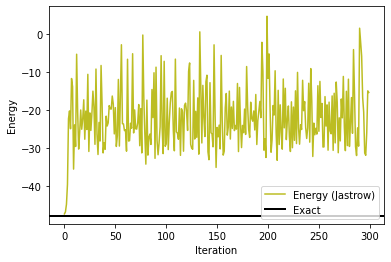

In [132]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]
sigmazs = data_Jastrow["sigmaz"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
# plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

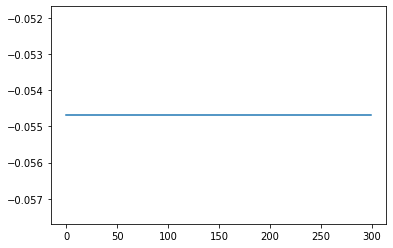

In [133]:
plt.plot(iters_Jastrow, sigmazs)